# SMYLE & DPLE Global Surface Temperature Skill

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Data I/O using Dask

### Create Dask Cluster

In [56]:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [5]:
cluster

### Read in CAM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [6]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [7]:
# This preprocessor will return a monthly mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    d0 = cal.time_set_midmonth(ds0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time']]
    d0 = d0.chunk({'L':-1})
    return d0

In [8]:
%%time
# SMYLE-NOV TS data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunk = {'M':20,'L':8}
chunk = {}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

CPU times: user 38.6 s, sys: 20.5 s, total: 59.1 s
Wall time: 1min 6s


5.202261672

In [9]:
smyle11

<xarray.Dataset>
Dimensions:  (M: 20, Y: 49, L: 24, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * L        (L) int64 1 2 3 4 5 6 7 8 9 10 11 ... 15 16 17 18 19 20 21 22 23 24
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Data variables:
    TS       (Y, L, M, lat, lon) float32 dask.array<chunksize=(1, 24, 1, 192, 288), meta=np.ndarray>
    time     (Y, L) object dask.array<chunksize=(1, 24), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSMYLE.f09_g17.1970-11.001
    logname:           sglanvil
    host:              cheyenne4
    initial_file:      b.e21.SMYLE_IC.f09_g17.1970-11.01.cam.i.1970-11-01-000...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [10]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).load()
#smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()
#daskresult = wait(smyle11_seas)

CPU times: user 45 s, sys: 6.53 s, total: 51.6 s
Wall time: 53 s


In [11]:
smyle11_seas

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, L: 8, Y: 49, M: 20)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * L        (L) int64 3 6 9 12 15 18 21 24
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Data variables:
    TS       (Y, L, M, lat, lon) float64 257.9 257.9 257.9 257.9 ... nan nan nan
    time     (Y, L) object 1971-01-15 00:00:00 ... 2020-10-15 00:00:00
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSMYLE.f09_g17.1970-11.001
    logname:           sglanvil
    host:              cheyenne4
    initial_file:      b.e21.SMYLE_IC.f09_g17.1970-11.01.cam.i.1970-11-01-000...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [12]:
%%time
# SMYLE-FEB TS data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunk = {'M':20,'L':8}
chunk = {}
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

CPU times: user 38.5 s, sys: 20.1 s, total: 58.6 s
Wall time: 1min 1s


5.202261672

In [13]:
%%time
smyle02_seas = cal.mon_to_seas_dask(smyle02).load()
#smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()
#daskresult = wait(smyle02_seas)

CPU times: user 46.5 s, sys: 5.33 s, total: 51.9 s
Wall time: 53.9 s


In [14]:
%%time
# SMYLE-MAY TS data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 35.9 s, sys: 18.4 s, total: 54.3 s
Wall time: 57.1 s


5.202261672

In [15]:
%%time
smyle05_seas = cal.mon_to_seas_dask(smyle05).load()
#smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()
#daskresult = wait(smyle05_seas)

CPU times: user 43.1 s, sys: 5.13 s, total: 48.3 s
Wall time: 50.7 s


In [16]:
%%time
# SMYLE-AUG TS data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 36.2 s, sys: 18.5 s, total: 54.8 s
Wall time: 58.3 s


5.202261672

In [17]:
%%time
smyle08_seas = cal.mon_to_seas_dask(smyle08).load()
#smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()
#daskresult = wait(smyle08_seas)

CPU times: user 44.6 s, sys: 5.03 s, total: 49.6 s
Wall time: 51.5 s


In [18]:
%%time
# DPLE-NOV TS data
# process all 40 ensemble members, all start dates from 1970-2018:
field = 'TS'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
ens = 40
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
dple11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
dple11.nbytes/1e9 #GB

CPU times: user 14.1 s, sys: 2.55 s, total: 16.6 s
Wall time: 20.6 s


10.192172672

In [19]:
%%time
dple11_seas = cal.mon_to_seas_dask(dple11).load()
#dple11_seas = cal.mon_to_seas_dask(dple11).persist()
#daskresult = wait(dple11_seas)

CPU times: user 1min 31s, sys: 10.9 s, total: 1min 42s
Wall time: 1min 46s


### DataArrays are manageable size now (and in memory), so Dask cluster could be released 

In [28]:
cluster.close()
client.close()

In [20]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_seas.to_netcdf(outdir+'DPLE11_SAT_seas.nc')
smyle11_seas.to_netcdf(outdir+'SMYLE11_SAT_seas.nc')
smyle02_seas.to_netcdf(outdir+'SMYLE02_SAT_seas.nc')
smyle05_seas.to_netcdf(outdir+'SMYLE05_SAT_seas.nc')
smyle08_seas.to_netcdf(outdir+'SMYLE08_SAT_seas.nc')

CPU times: user 233 ms, sys: 5.94 s, total: 6.18 s
Wall time: 7.1 s


In [ ]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_seas = xr.open_dataset(outdir+'DPLE11_SAT_seas.nc')
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_SAT_seas.nc')
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_SAT_seas.nc')
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_SAT_seas.nc')
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_SAT_seas.nc')

### Get surface temperature OBS

In [21]:
# CRU TS4.05  (0.5deg SAT over land)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_cru = xr.open_dataset(obs_dir+'mon/SAT/cru_ts4.05.1901.2020.tmp.dat.nc',decode_times=False)
cru_montime_vals = [cftime.DatetimeNoLeap(1901+year, 1+month, 15) for year in range(120) for month in range(12)]
ds_cru['time'] = cru_montime_vals
ds_cru = ds_cru.sel(time=slice("1960","2020"))

In [22]:
# ERSSTv5  (2deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_ersstv5 = xr.open_dataset(obs_dir+'mon/SST/ersst.v5.188001-202012.nc')
nt = np.size(ds_ersstv5.time)
ersstv5_montime_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
ds_ersstv5['time'] = ersstv5_montime_vals
ds_ersstv5 = ds_ersstv5.sel(time=slice("1960","2020"))

In [23]:
# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_hadisst = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc').sel(time=slice("1870","2020"))
nt = np.size(ds_hadisst.time)
hadisst_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
ds_hadisst['time'] = hadisst_montime_vals
ds_hadisst['sst'] = xr.where(ds_hadisst['sst']<-2,-1.8,ds_hadisst['sst'])
ds_hadisst = ds_hadisst.sel(time=slice("1960","2020"))

In [24]:
ds_hadisst

<xarray.Dataset>
Dimensions:    (time: 732, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) object 1960-01-15 00:00:00 ... 2020-12-15 00:00:00
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    5/7/2021 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

### Compute OBS seasonal averages

In [25]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [26]:
cru_ts_seas = obs_convert_mon_to_seas(ds_cru.tmp,'TS')

In [27]:
ersstv5_ts_seas = obs_convert_mon_to_seas(ds_ersstv5.sst,'TS')

In [28]:
hadisst_ts_seas = obs_convert_mon_to_seas(ds_hadisst.sst,'TS')

### Regrid OBS to CAM grid

In [29]:
import xesmf as xe

In [30]:
%%time
regridder_cru = xe.Regridder(cru_ts_seas, smyle11, 'bilinear', periodic=True)
cru_ts_seas_rg = regridder_cru(cru_ts_seas.TS)

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 5.4 s, sys: 408 ms, total: 5.81 s
Wall time: 5.97 s


In [31]:
%%time
regridder_hadisst = xe.Regridder(hadisst_ts_seas, smyle11, 'bilinear', periodic=True)
hadisst_ts_seas_rg = regridder_hadisst(hadisst_ts_seas.TS)

CPU times: user 2.43 s, sys: 211 ms, total: 2.64 s
Wall time: 2.74 s


### Merge OBS datasets

In [32]:
def merge_obs(da1,da2):
    return da1.fillna(da2)

In [33]:
# merged CRU/HadISST
#cruhadisst = merge_obs_camgrid(cru_ts_seas_rg,hadisst_ts_seas_rg,fv1_landmask.LANDFRAC,0.5)
cruhadisst = merge_obs(cru_ts_seas_rg,hadisst_ts_seas_rg)

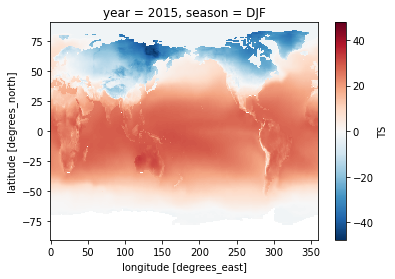

In [34]:
cruhadisst.isel(season=0).sel(year=2015).plot();

In [35]:
## convert OBS to anomalies from 1972-2017
cruhadisst = cruhadisst - cruhadisst.sel(year=slice(1972,2017)).mean('year')

# Anomaly Correlation Plots

In [28]:
%%time
# SKIP this.. could not get chunking and dask to speed things up
#chunks = {'M':1}
# Compute de-drifted anomalies from 1972-2017 climatology
#smyle11_anom,smyle11_clim = stat.remove_drift(smyle11.chunk(chunks),smyle11.time,1972,2017)
#dple11_anom,dple11_clim = stat.remove_drift(dple11.chunk(chunks),dple11.time,1972,2017)
#smyle02_anom,smyle02_clim = stat.remove_drift(smyle02.chunk(chunks),smyle02.time,1972,2017)
#smyle05_anom,smyle05_clim = stat.remove_drift(smyle05.chunk(chunks),smyle05.time,1972,2017)
#smyle08_anom,smyle08_clim = stat.remove_drift(smyle08.chunk(chunks),smyle08.time,1972,2017)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


In [36]:
%%time
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11_seas,smyle11_seas.time,1972,2017)
dple11_anom,dple11_clim = stat.remove_drift(dple11_seas,dple11_seas.time,1972,2017)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02_seas,smyle02_seas.time,1972,2017)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05_seas,smyle05_seas.time,1972,2017)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08_seas,smyle08_seas.time,1972,2017)

CPU times: user 18.4 s, sys: 14.2 s, total: 32.6 s
Wall time: 34.3 s


In [37]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_corr_byseas(mod_da,mod_time,obs_da,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [38]:
smyle11_seas.isel(L=0).time.dt.month

<xarray.DataArray 'month' (Y: 49)>
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])
Coordinates:
    L        int64 3
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018

In [39]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.TS,smyle11_seas.time,cruhadisst)
dple11_corr = leadtime_corr_byseas(dple11_anom.TS,dple11_seas.time,cruhadisst)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.TS,smyle02_seas.time,cruhadisst)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.TS,smyle05_seas.time,cruhadisst)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.TS,smyle08_seas.time,cruhadisst)

CPU times: user 18.5 s, sys: 8.97 s, total: 27.4 s
Wall time: 28.2 s


CPU times: user 43.7 s, sys: 46.3 ms, total: 43.7 s
Wall time: 45.2 s


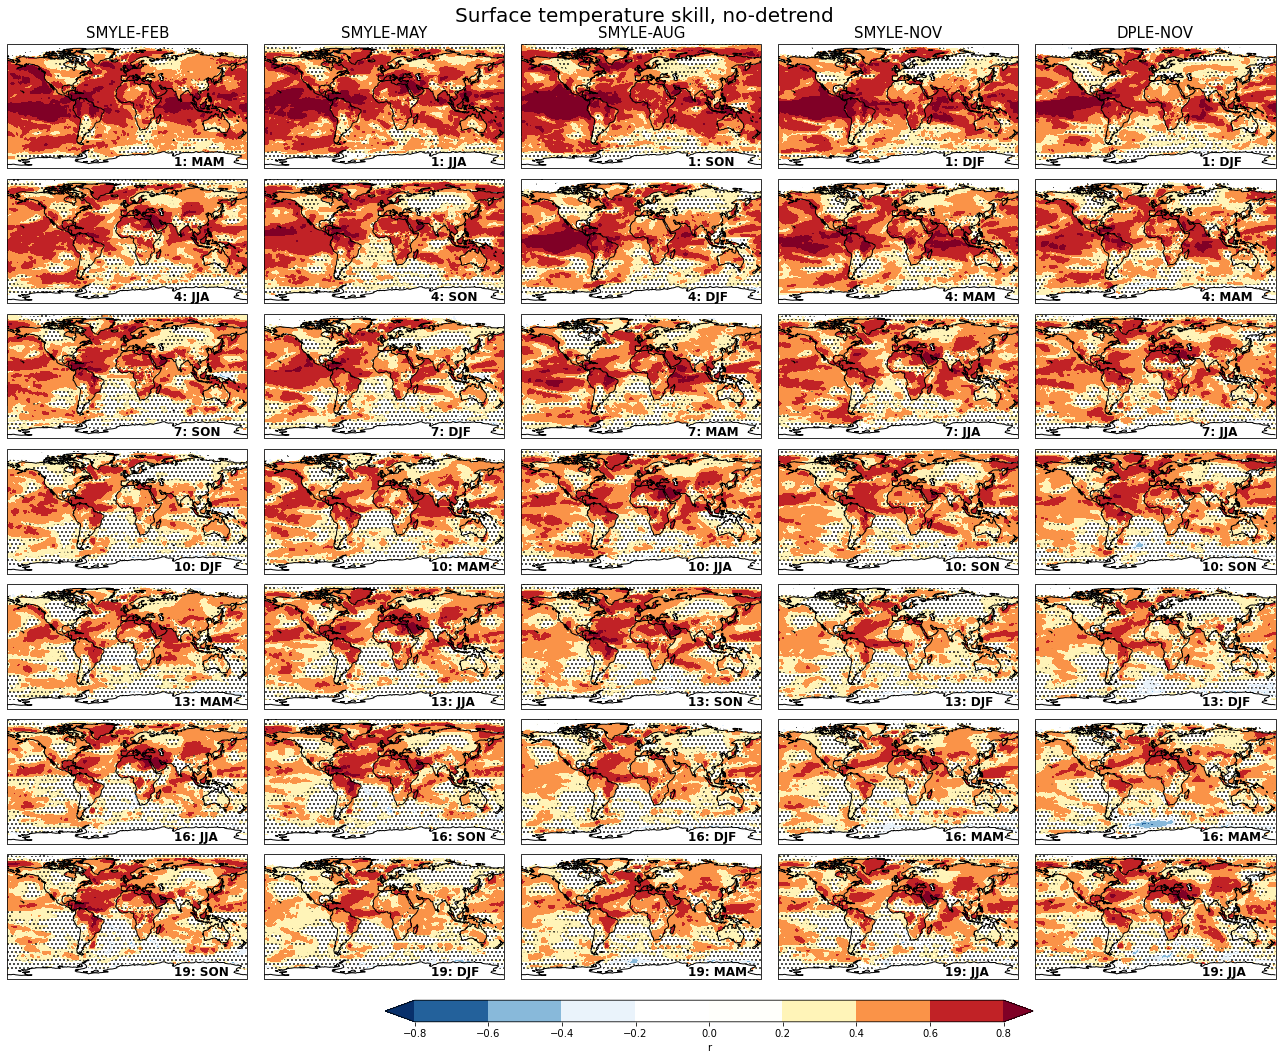

In [40]:
%%time
ci = 0.2
cmin = -0.8
cmax = 0.8
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj,extend='both')
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj,extend='both')
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj,extend='both')
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj,extend='both')
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj,extend='both')
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')

### Test Significance Hatching using correlation p-values

CPU times: user 1.22 s, sys: 1.21 ms, total: 1.22 s
Wall time: 1.24 s


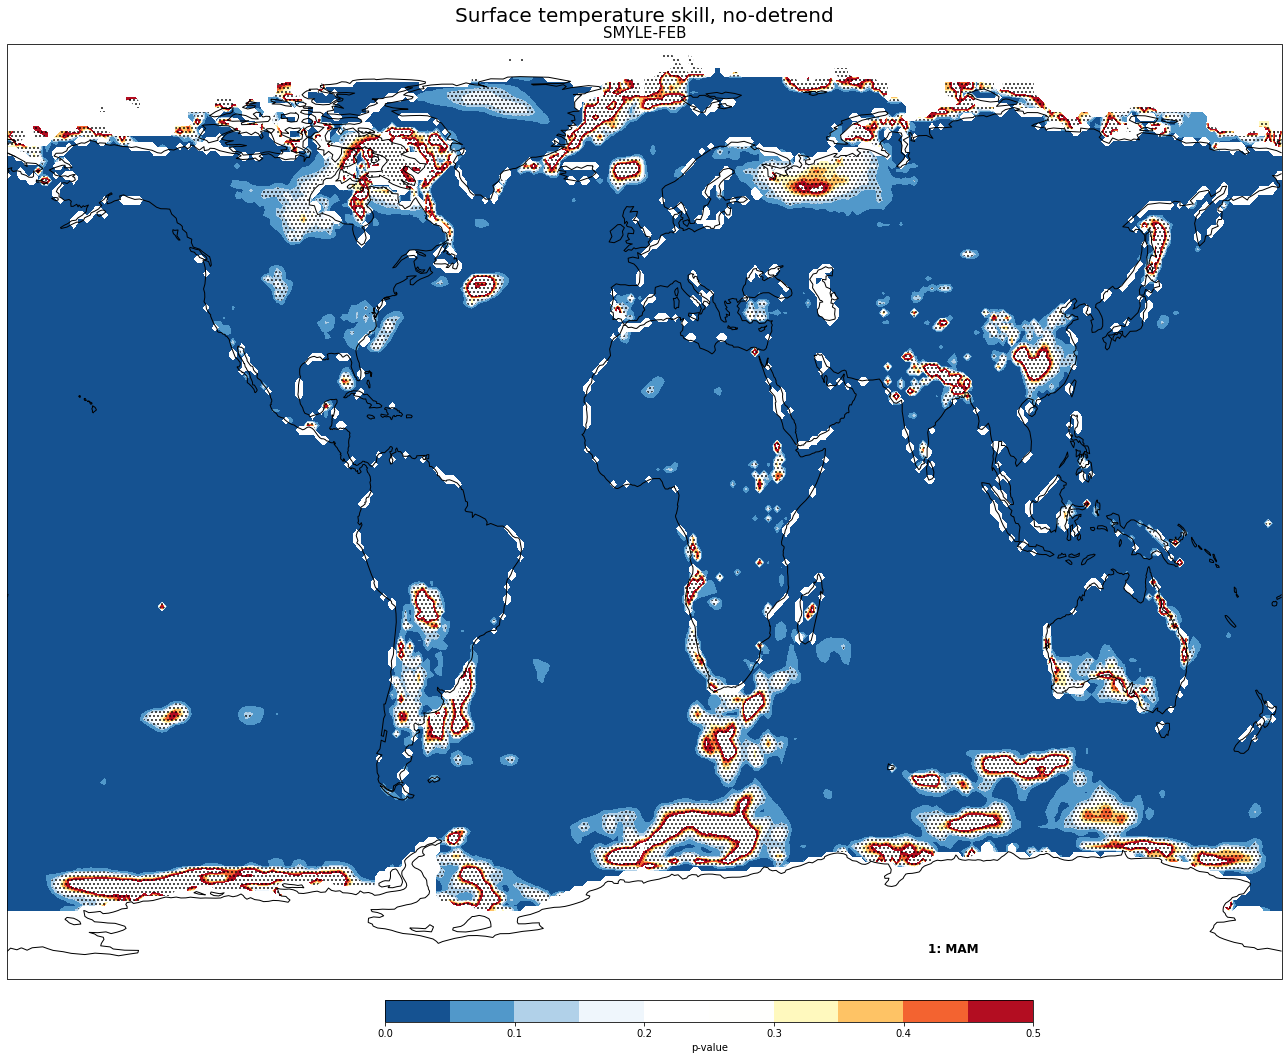

In [41]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...','...'], alpha=0.)
    ldstr = str(i+1) + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle('Surface temperature skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [42]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.TS,smyle11_seas.time,cruhadisst,detrend=True)
dple11_corr = leadtime_corr_byseas(dple11_anom.TS,dple11_seas.time,cruhadisst,detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.TS,smyle02_seas.time,cruhadisst,detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.TS,smyle05_seas.time,cruhadisst,detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.TS,smyle08_seas.time,cruhadisst,detrend=True)

CPU times: user 38.3 s, sys: 9.73 s, total: 48 s
Wall time: 49.7 s


CPU times: user 1min 11s, sys: 134 ms, total: 1min 11s
Wall time: 1min 13s


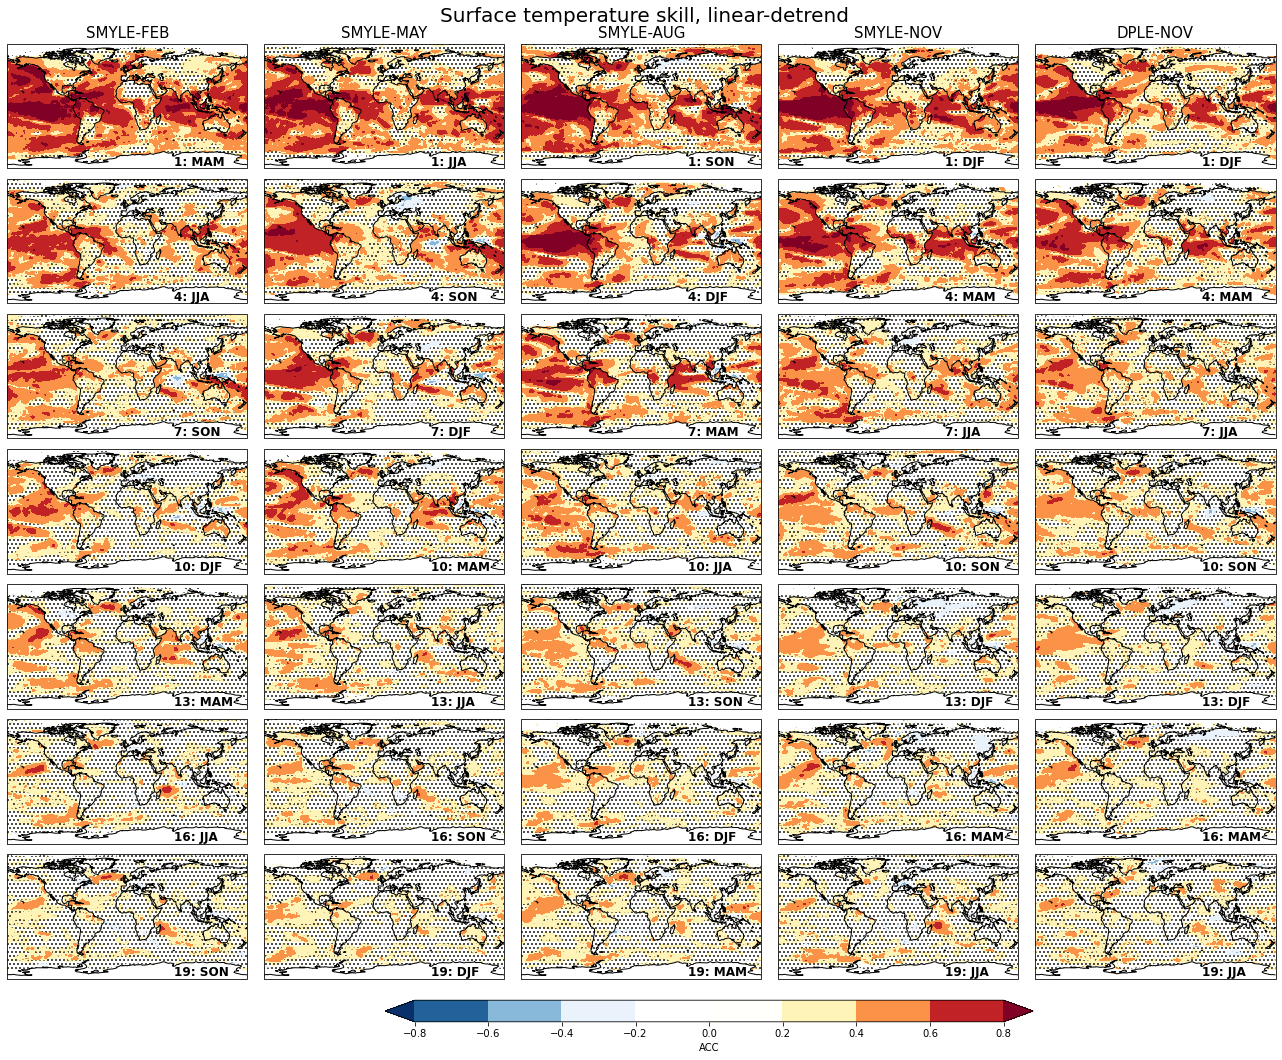

In [43]:
%%time
ci = 0.2
cmin = -0.8
cmax = 0.8
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj,extend='both')
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj,extend='both')
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj,extend='both')
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj,extend='both')
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj,extend='both')
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig_SATskillmaps.png')

### Look at subsampled skill maps

In [44]:
hadisst_ts_seas.TS.sel(year=slice(1970,2018)).year

<xarray.DataArray 'year' (year: 49)>
array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])
Coordinates:
  * year     (year) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018

In [45]:
obs_dat = hadisst_ts_seas.TS.sel(year=slice(1970,2018))
obs_nino34 = obs_dat.sel(latitude=slice(5,-5)).sel(longitude=slice(-170,-120)).mean(("longitude", "latitude"))

In [46]:
obs_nino34 = obs_nino34 - obs_nino34.mean('year')
obs_nino34 = obs_nino34/obs_nino34.std('year')

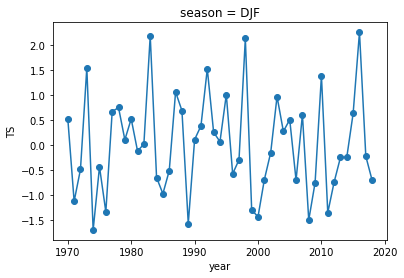

In [47]:
obs_nino34.sel(season='DJF').plot(marker='o');

In [48]:
bignino = obs_nino34.where(abs(obs_nino34)>1)

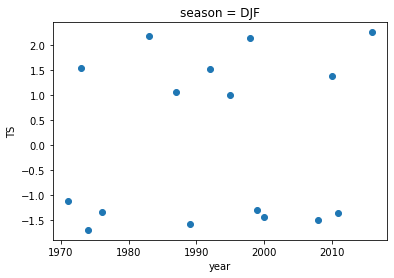

In [49]:
bignino.sel(season='DJF').plot(marker='o',linestyle="none");

In [50]:
bignino.sel(season='DJF').dropna(dim='year').year

<xarray.DataArray 'year' (year: 16)>
array([1971, 1973, 1974, 1976, 1983, 1987, 1989, 1992, 1995, 1998, 1999, 2000,
       2008, 2010, 2011, 2016])
Coordinates:
  * year     (year) int64 1971 1973 1974 1976 1983 ... 2000 2008 2010 2011 2016
    season   <U3 'DJF'

In [51]:
keepyears = bignino.sel(season='DJF').dropna(dim='year').year.data

In [52]:
keepyears

array([1971, 1973, 1974, 1976, 1983, 1987, 1989, 1992, 1995, 1998, 1999,
       2000, 2008, 2010, 2011, 2016])

In [53]:
def leadtime_corr_byseas_subsamp(mod_da,mod_time,obs_da,keep,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M').sel(Y=keep)
    mod_time = mod_time.sel(Y=keep)
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        verify_year = mod_time.sel(L=i).dt.year.data
        verify_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[verify_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",verify_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [54]:
%%time
keep11 = (keepyears-1)
keep02 = keepyears
keep05 = keepyears
keep08 = (keepyears-1)
smyle11_corr = leadtime_corr_byseas_subsamp(smyle11_anom.TS,smyle11_seas.time,cruhadisst,keep11,detrend=True)
dple11_corr = leadtime_corr_byseas_subsamp(dple11_anom.TS,dple11_seas.time,cruhadisst,keep11,detrend=True)
smyle02_corr = leadtime_corr_byseas_subsamp(smyle02_anom.TS,smyle02_seas.time,cruhadisst,keep02,detrend=True)
smyle05_corr = leadtime_corr_byseas_subsamp(smyle05_anom.TS,smyle05_seas.time,cruhadisst,keep05,detrend=True)
smyle08_corr = leadtime_corr_byseas_subsamp(smyle08_anom.TS,smyle08_seas.time,cruhadisst,keep08,detrend=True)

CPU times: user 31.3 s, sys: 8.05 s, total: 39.3 s
Wall time: 40.7 s


CPU times: user 1min 11s, sys: 149 ms, total: 1min 11s
Wall time: 1min 14s


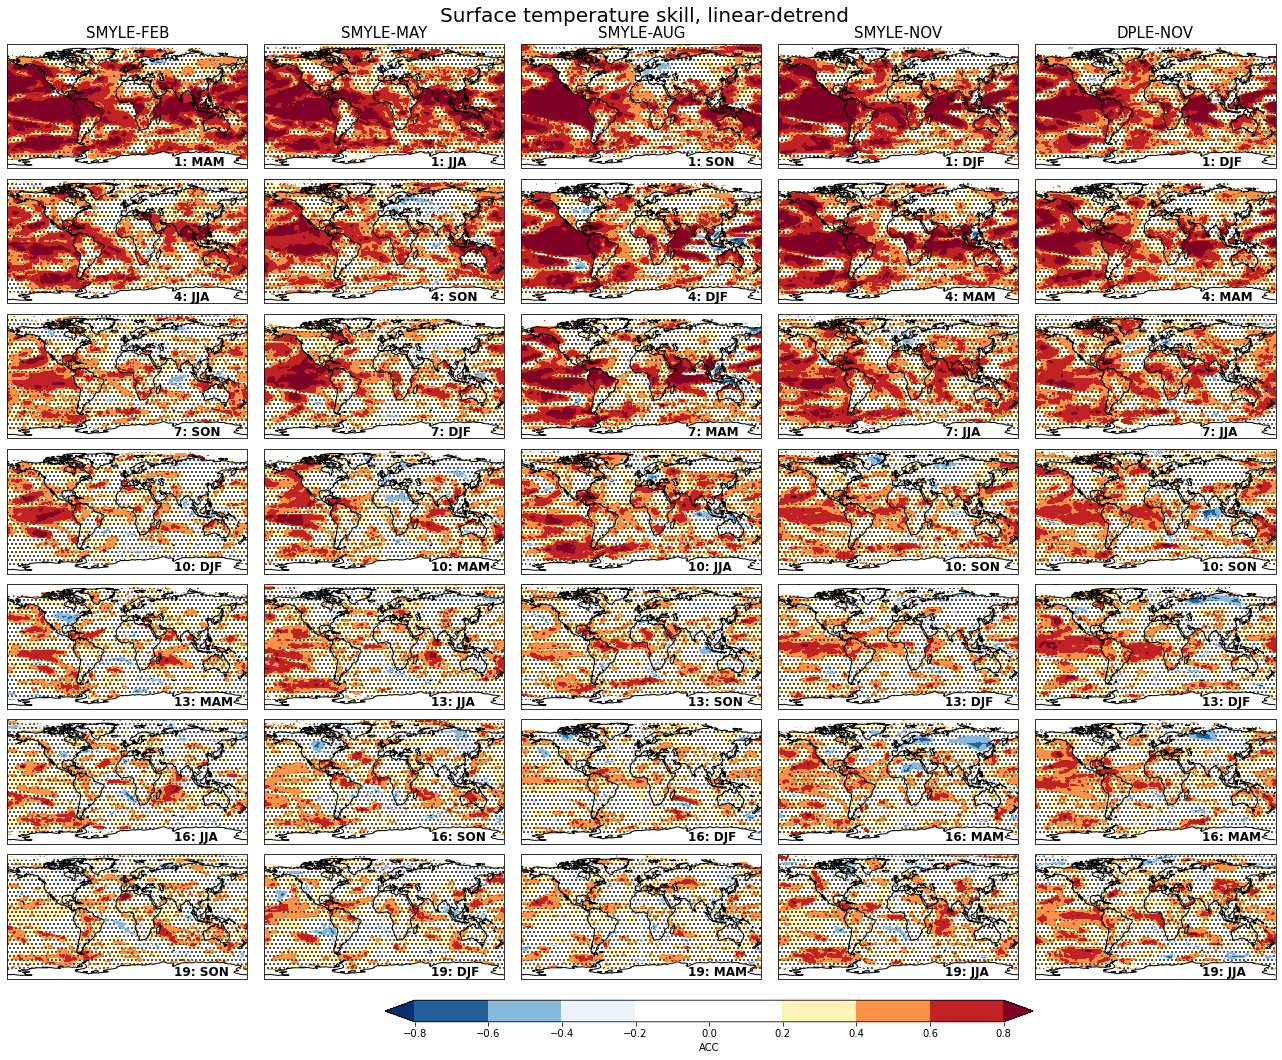

In [55]:
%%time
ci = 0.2
cmin = -0.8
cmax = 0.8
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj,extend='both')
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj,extend='both')
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj,extend='both')
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj,extend='both')
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj,extend='both')
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('Fig_SATskillmaps_subsamp.png')

### Test skill sensitivity to OBS dataset: use HadCRU5-ERSSTv5

In [68]:
# Xian Wu's merged HadCRU5-ERSSTv5 data on CAM fv1 grid
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_obs = xr.open_dataset(obs_dir+'mon/merge_ocean_land_data/merge-ts-sst-obsdata-HadCRUT5-ERSSTv5-1900-2020.nc')
nt = np.size(ds_obs.time)
obs_montime_vals = [cftime.DatetimeNoLeap(1900+year, 1+month, 15) for year in range(121) for month in range(12)]
ds_obs['time'] = obs_montime_vals
ds_obs = ds_obs.sel(time=slice("1960","2020"))

In [69]:
obs_ts_seas = obs_convert_mon_to_seas(ds_obs.ts,'TS').TS

In [70]:
## convert OBS to anomalies from 1972-2017
obs_ts_seas = obs_ts_seas - obs_ts_seas.sel(year=slice(1972,2017)).mean('year')

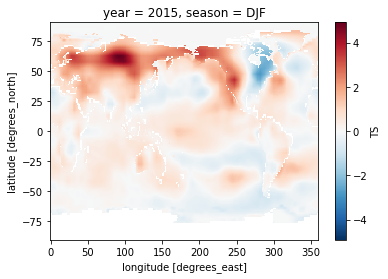

In [71]:
obs_ts_seas.isel(season=0).sel(year=2015).plot();

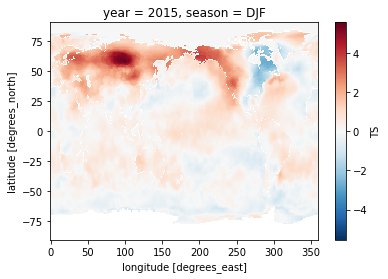

In [72]:
cruhadisst.isel(season=0).sel(year=2015).plot();

In [73]:
## need to correct obs grid which is slightly off:
obs_ts_seas = obs_ts_seas.assign_coords(lat=("lat",smyle11.lat.data)).assign_coords(lon=("lon",smyle11.lon.data))

In [81]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.TS,smyle11.time,obs_ts_seas,detrend=True)
dple11_corr = leadtime_corr_byseas(dple11_anom.TS,dple11.time,obs_ts_seas,detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.TS,smyle02.time,obs_ts_seas,detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.TS,smyle05.time,obs_ts_seas,detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.TS,smyle08.time,obs_ts_seas,detrend=True)

CPU times: user 37.8 s, sys: 9.14 s, total: 47 s
Wall time: 44.9 s


CPU times: user 44.9 s, sys: 133 ms, total: 45.1 s
Wall time: 44.9 s


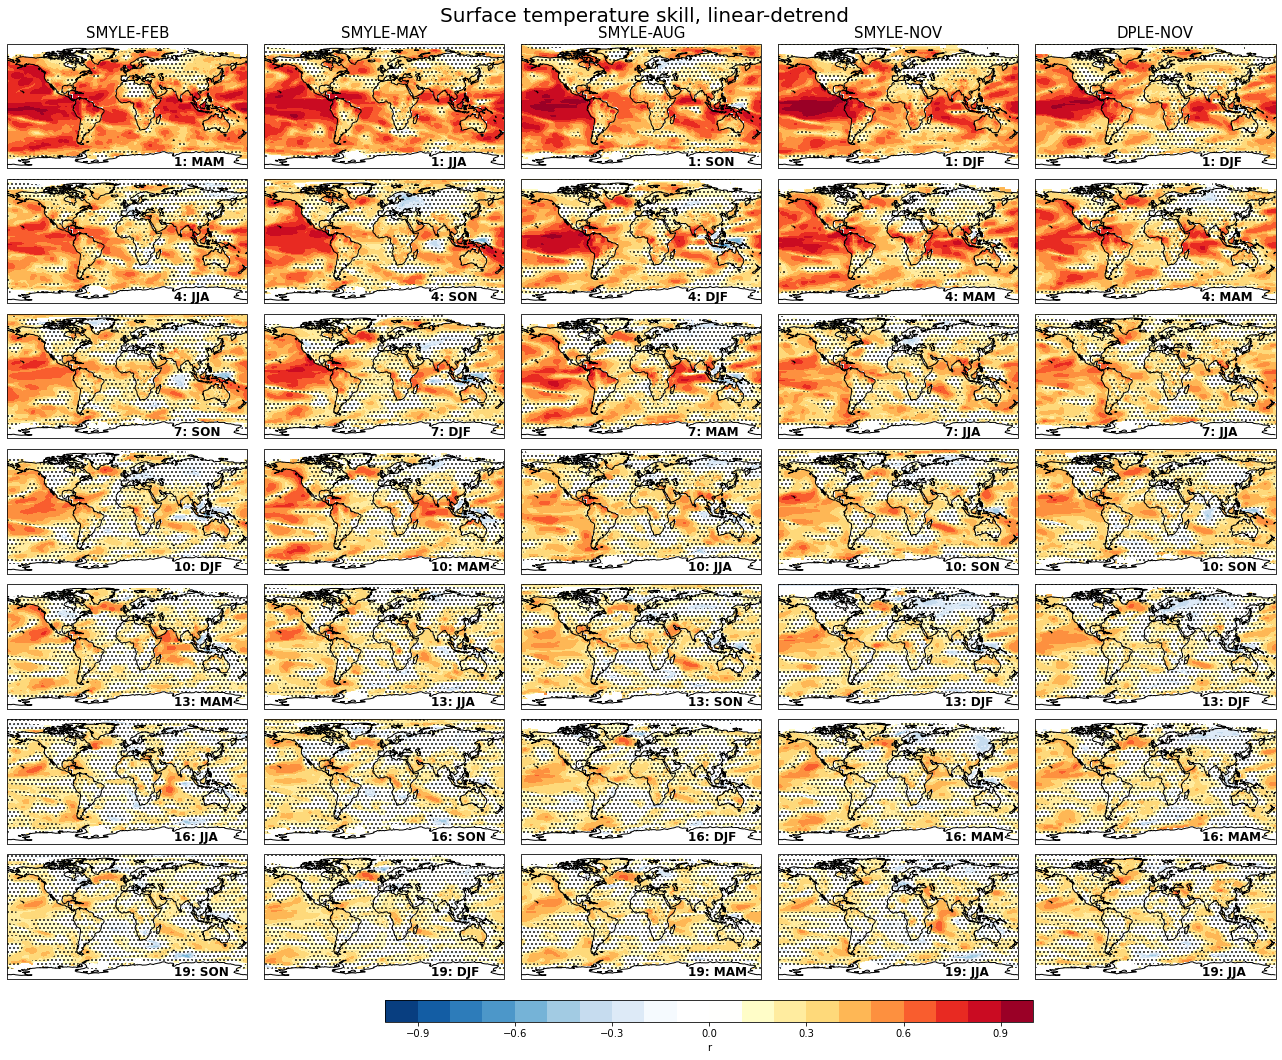

In [82]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
plt.savefig('Fig_1b.png')